In [9]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google'

In [1]:
import numpy as np
import pandas as pd

/var/folders/k3/_dfd862s3y38r1cp2wgc2c4w0000gp/T/ipykernel_68219/1662815981.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
print(np.pi)

3.141592653589793


# DATA LOADING

In [ ]:
pd.set_option('display.float_format',lambda x: '%.2f' % x)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/bank_transactions.csv')
data

In [ ]:
data.shape

The dataset has 10,48,567 rows with 9 features for each datapoint.

In [ ]:
data.describe()

To note:-
- The max account balance is much much larger than the 50% and the 70% percentile balances, which may indicate an outlier,
- However, considering that this are real world balances, it is possible for one individual to have larger balance in comparison to most, so we will ignore it.
- Same goes for transaction amount.
- The minimum transaction time is "0.00" and maximum is "235959". This indicates that the time is actually a 6 digit string in the 24h format and not an integer. So we would treat it as such in the future.


In [ ]:
data.info()

The number of rows are 104857 but there are some features like CustomerDOB, CustGender and CustLocation that appear to have lesser non-null values which indicates the presence of null values in these columns.

# DATA CLEANING

In [ ]:
data.isnull().sum()

In [ ]:
data['CustAccountBalance'] = data['CustAccountBalance'].fillna(0)
data = data[~data['CustGender'].isna()]
data = data[~data['CustomerDOB'].isna()]
data = data[~data['CustLocation'].isna()]

To note:
- The balances that are shown as "NA" have been converted to 0, because it is possible for zero balances to be shown as null in the dataset.
- The rows with missing gender, location and DOB are removed because we would require these features to analyse a customer's spending habits based on his/her's demographic. So if they are absent, the datapoint is not required for our model.

In [ ]:
data.isnull().sum()

There are no more null values in the dataset.


In [ ]:
sorted([x for x in data['CustomerDOB']])

In [ ]:
data['CustomerDOB'].describe()

In [ ]:
grouped_data = data.groupby('CustomerDOB').size().reset_index(name='num_cells')
grouped_data = grouped_data.sort_values(by='num_cells', ascending=False)
print(grouped_data)

On doing a preliminary checking of unique birthdates, we see that an unusually large number of birthdates show the year value as 1800. This seems to be incorrect, so we remove those rows from the dataset.

In [ ]:
data['CustomerDOB'] = data['CustomerDOB'].replace('1/1/1800', np.nan)
data = data[~data['CustomerDOB'].isna()]
data.shape

In [ ]:
grouped_data = data.groupby('CustomerDOB').size().reset_index(name='num_cells')
grouped_data = grouped_data.sort_values(by='num_cells', ascending=False)
print(grouped_data)

In [ ]:
data['CustomerDOB'].describe()

In [ ]:
data = data.drop(['TransactionID','CustomerID'],axis=1)

We removed the transaction ID and customer ID from the dataset as they would not be useful in our model for segmentation or any other analysis.

In [ ]:
data

In [ ]:
data['CustGender'].value_counts()

In [ ]:
data.shape

After dropping null and incorrect rows, we have 9,87,516 rows left.

# FEATURE ENGINEERING

<What is feature engineering and why are we doing it>


The transaction date is not useful to us since we cannot classify those dates into months/years/weekdays individually every single time. So we split it into different categorical columns for ease of analysis.

In [ ]:
data.TransactionDate = pd.to_datetime(data.TransactionDate,errors='coerce')
data['TransactionYear'] = data.TransactionDate.dt.year
data['TransactionMonth'] = data.TransactionDate.dt.month
data['TransactionMonthName'] = data.TransactionDate.dt.month_name()
data['TransactionDay'] = data.TransactionDate.dt.day
data['TransactionDayName'] = data.TransactionDate.dt.day_name()
data

In [ ]:
data = data.drop('TransactionDate',axis=1)

In [ ]:
data

In [ ]:
print(data['CustomerDOB'])

In [ ]:
sorted([x[-2:] for x in data['CustomerDOB']])

In [ ]:
data['dob'] = pd.to_datetime(data.CustomerDOB, errors = 'coerce')

In [ ]:
data.loc[data['dob'].dt.year > 2015, 'dob'] -= pd.DateOffset(years=100)

In [ ]:
from datetime import datetime
data['dob'] = pd.to_datetime(data['dob'])
current_date = datetime.now()
data['age'] = (current_date - data['dob']).dt.days // 365
print(data)

In [ ]:
from datetime import date

def age(birthdate):
    today = date.today()
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

In [ ]:
data['Age'] = data.CustomerDOB.apply(age)

In [ ]:
data = data[data['Age']>15]
data.drop('CustomerDOB',axis=1,inplace=True)
data.shape

<ipython-input-345-ba3412c81bc1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('CustomerDOB',axis=1,inplace=True)


(893292, 12)

In [ ]:
data

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),TransactionYear,TransactionMonth,TransactionMonthName,TransactionDay,TransactionDayName,dob,Age
0,F,JAMSHEDPUR,17819.05,143207,25.00,2016,2,February,8,Monday,1994-10-01,29
2,F,MUMBAI,17874.44,142712,459.00,2016,2,February,8,Monday,1996-11-26,27
4,F,NAVI MUMBAI,6714.43,181156,1762.50,2016,2,February,8,Monday,1988-03-24,35
6,F,MUMBAI,973.46,173806,566.00,2016,2,February,8,Monday,1992-01-26,32
7,M,MUMBAI,95075.54,170537,148.00,2016,2,February,8,Monday,1982-01-27,42
...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,M,NEW DELHI,7635.19,184824,799.00,2016,9,September,18,Sunday,1990-08-04,33
1048563,M,NASHIK,27311.42,183734,460.00,2016,9,September,18,Sunday,1992-02-20,31
1048564,M,HYDERABAD,221757.06,183313,770.00,2016,9,September,18,Sunday,1989-05-18,34
1048565,M,VISAKHAPATNAM,10117.87,184706,1000.00,2016,9,September,18,Sunday,1978-08-30,45


In [ ]:
data.shape

(893292, 12)

In [ ]:
sorted_age = sorted(data['Age'])
unique_age = sorted(set(sorted_age))[:50]  # Convert to set to get unique values and slice to get only the top 50
print(unique_age)

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


# EXPLORATORY DATA ANALYSIS

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Box Plots and Distribution Plots

### Distribution Plot:
Theory: This plot illustrates the distribution of the data for the selected column. It helps in understanding the shape, spread, and central tendency of the data.

### Box Plot:
Theory: The box plot provides a visual representation of the distribution of the data's spread and identifies potential outliers. It displays the median, quartiles, and potential outliers in the data set.

### Quantile-Quantile Plot (Q-Q Plot):
Theory: The Q-Q plot compares the distribution of the selected column against a theoretical normal distribution. It helps in assessing whether the data follows a normal distribution or not. If the data points fall approximately along the diagonal line, it indicates that the data is normally distributed.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893292 entries, 0 to 1048566
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CustGender               893292 non-null  object        
 1   CustLocation             893292 non-null  object        
 2   CustAccountBalance       893292 non-null  float64       
 3   TransactionTime          893292 non-null  int64         
 4   TransactionAmount (INR)  893292 non-null  float64       
 5   TransactionYear          893292 non-null  int64         
 6   TransactionMonth         893292 non-null  int64         
 7   TransactionMonthName     893292 non-null  object        
 8   TransactionDay           893292 non-null  int64         
 9   TransactionDayName       893292 non-null  object        
 10  dob                      893292 non-null  datetime64[ns]
 11  Age                      893292 non-null  int64         
dtypes: datetime64[n

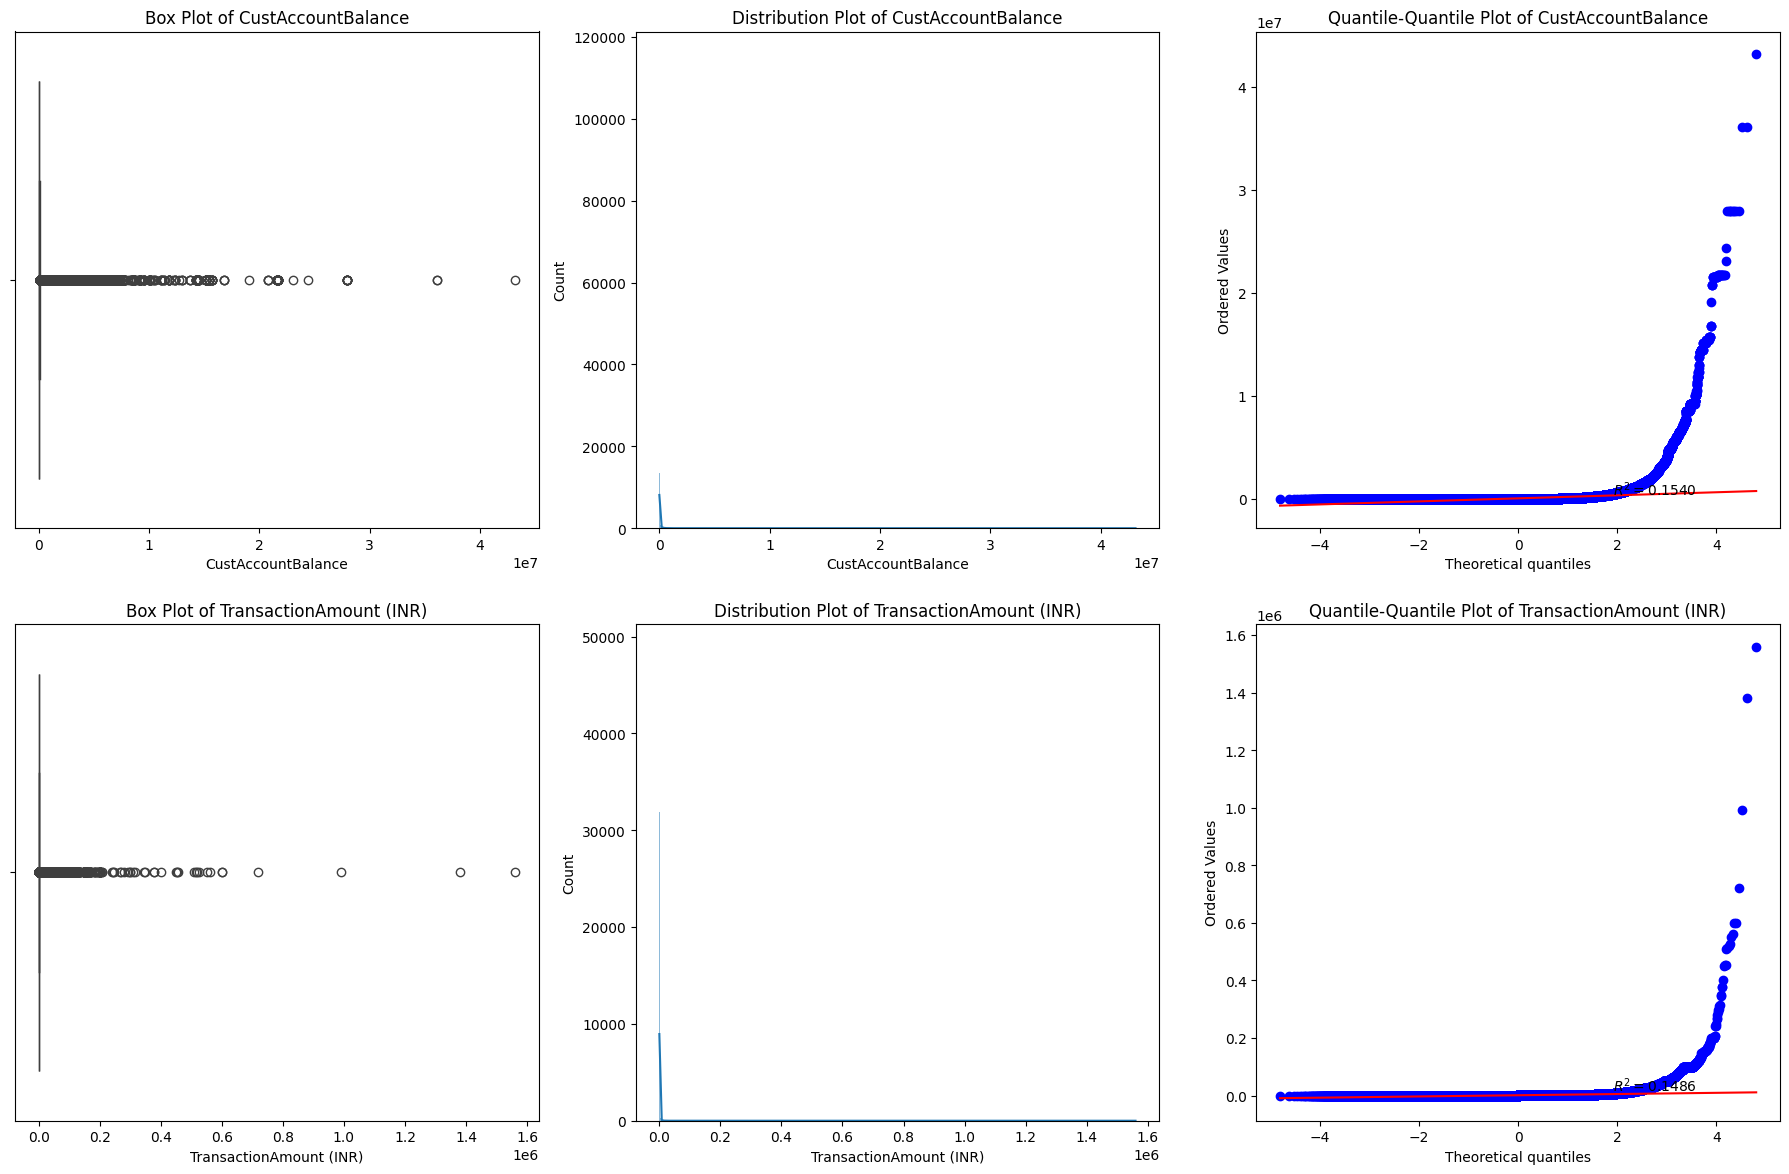

In [ ]:
numeric_cols = data.select_dtypes(include=[np.float64]).columns

fig, axes = plt.subplots(len(numeric_cols), 3, figsize=(18, len(numeric_cols) * 6))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=col, data=data, ax=axes[i, 0])
    axes[i, 0].set_title("Box Plot of {}".format(col))

    sns.histplot(x=col, data=data, ax=axes[i, 1], kde=True)
    axes[i, 1].set_title("Distribution Plot of {}".format(col))

    probplot(data[col], plot=axes[i, 2], rvalue=True)
    axes[i, 2].set_title("Quantile-Quantile Plot of {}".format(col))

plt.tight_layout()
plt.show()


# Gender Based Analysis ( Female and Male)

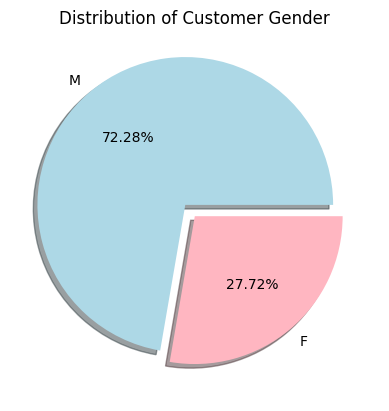

In [ ]:
labels = data.CustGender.value_counts().keys()
values = data.CustGender.value_counts().values
explode = (0.1, 0)

colors = ['lightblue', 'lightpink']

plt.pie(values, labels=labels, explode=explode, shadow=True, autopct='%1.2f%%', colors=colors)

plt.title('Distribution of Customer Gender')

plt.show()


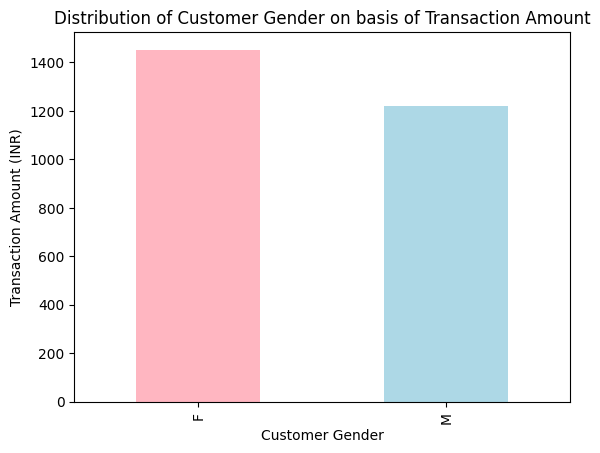

In [ ]:
ax = data.groupby('CustGender')['TransactionAmount (INR)'].mean().plot(kind='bar',color=['lightpink','lightblue'])
plt.ylabel('Transaction Amount (INR)')
plt.xlabel('Customer Gender')


plt.title('Distribution of Customer Gender on basis of Transaction Amount')
plt.show()


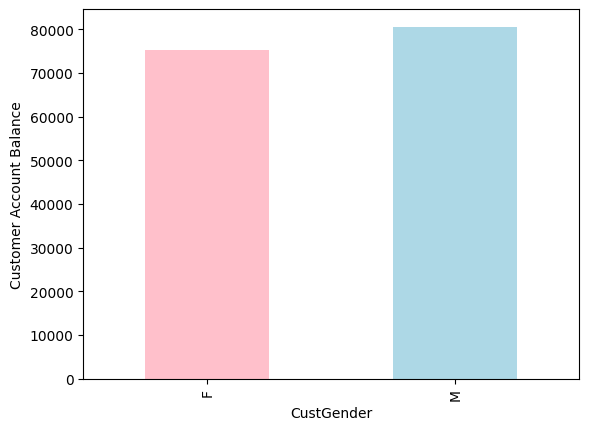

In [ ]:
ax = data.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',color=['pink','lightblue'])
plt.ylabel('Customer Account Balance');

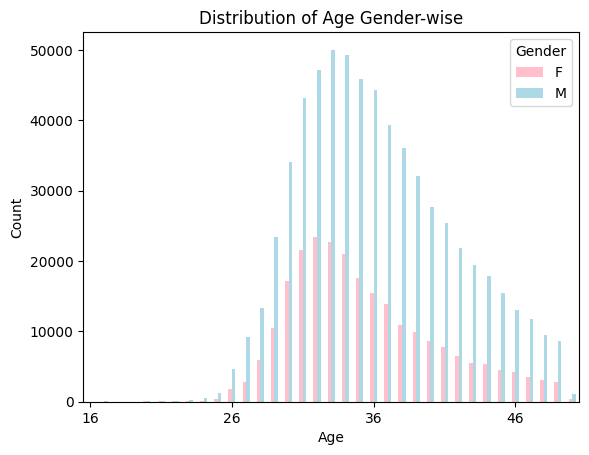

In [ ]:
age_gender_counts = data.groupby(['Age', 'CustGender']).size().unstack()

age_gender_counts = age_gender_counts.dropna()

ax = age_gender_counts.plot(kind='bar', color=['pink', 'lightblue'])

plt.xticks(range(0, len(age_gender_counts.index), 10), age_gender_counts.index[::10], rotation=0)

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age Gender-wise')
plt.legend(title='Gender')
plt.show()


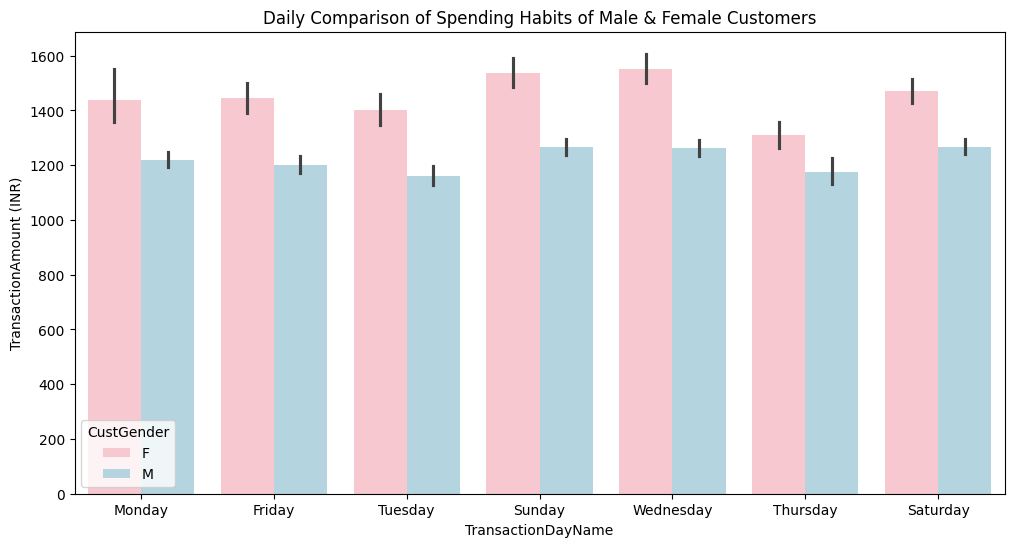

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='TransactionDayName', y='TransactionAmount (INR)', palette={'M': 'lightblue', 'F': 'pink'}, hue='CustGender')

plt.title('Daily Comparison of Spending Habits of Male & Female Customers')
plt.show()

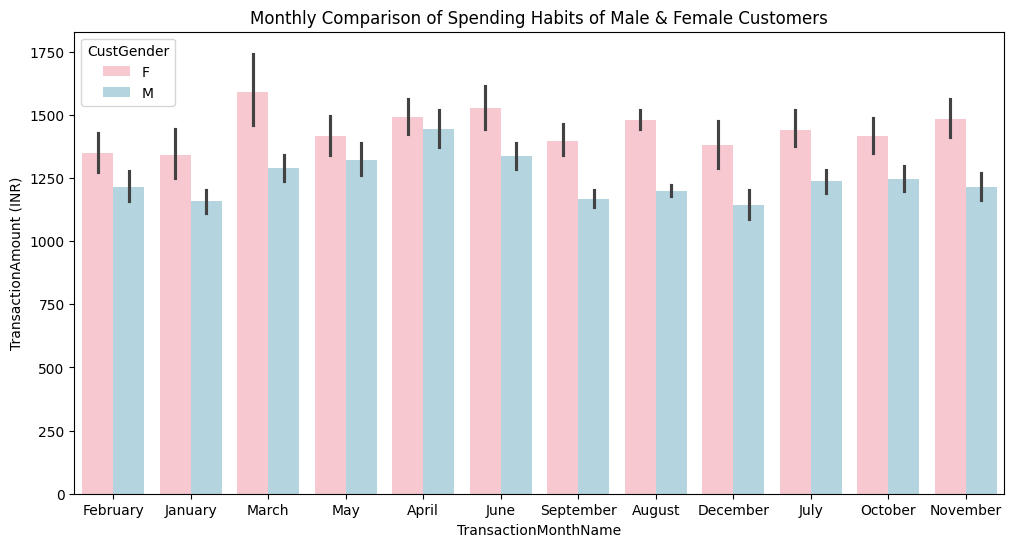

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='TransactionMonthName', y='TransactionAmount (INR)', palette={'M': 'lightblue', 'F': 'pink'}, hue='CustGender')

plt.title('Monthly Comparison of Spending Habits of Male & Female Customers')
plt.show()


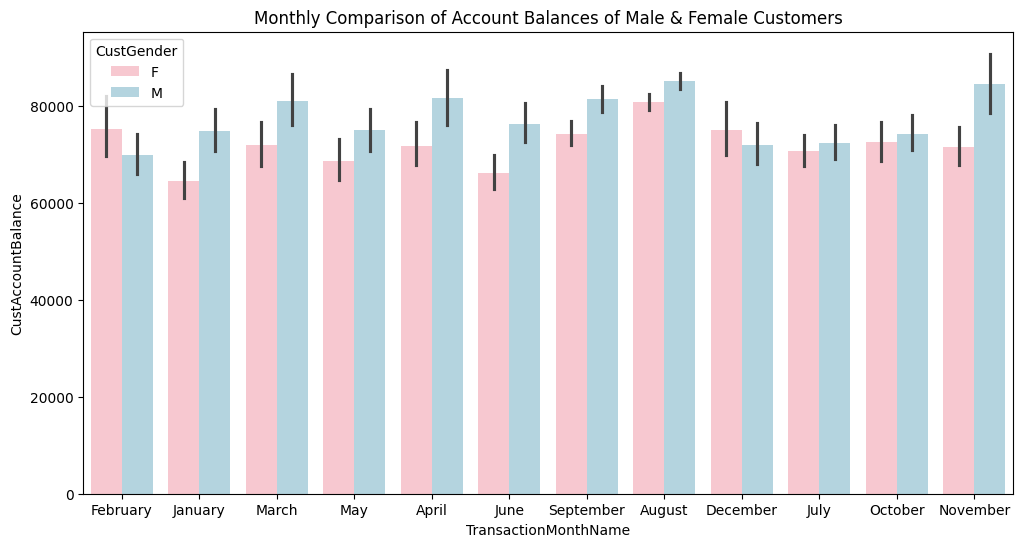

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='TransactionMonthName', y='CustAccountBalance', palette={'M': 'lightblue', 'F': 'pink'}, hue='CustGender')

plt.title('Monthly Comparison of Account Balances of Male & Female Customers')
plt.show()

# Location Based Analysis


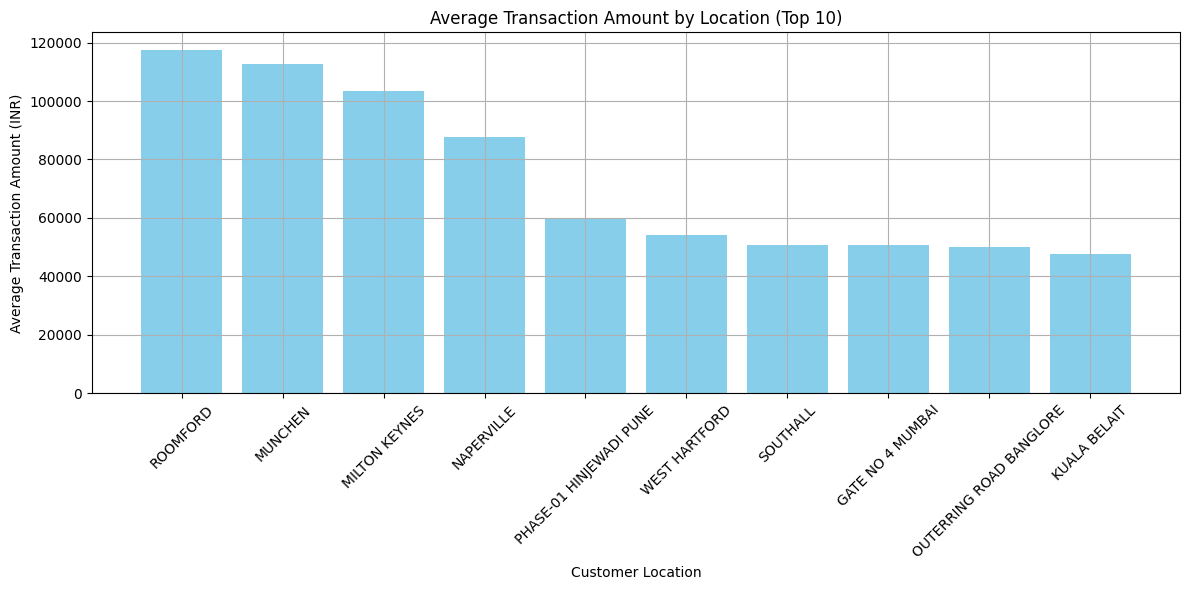

In [ ]:
grouped_data = data.groupby('CustLocation')['TransactionAmount (INR)'].mean().reset_index()

top_10_locations = grouped_data.sort_values(by='TransactionAmount (INR)', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_locations['CustLocation'], top_10_locations['TransactionAmount (INR)'], color='skyblue')
plt.title('Average Transaction Amount by Location (Top 10)')
plt.xlabel('Customer Location')
plt.ylabel('Average Transaction Amount (INR)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

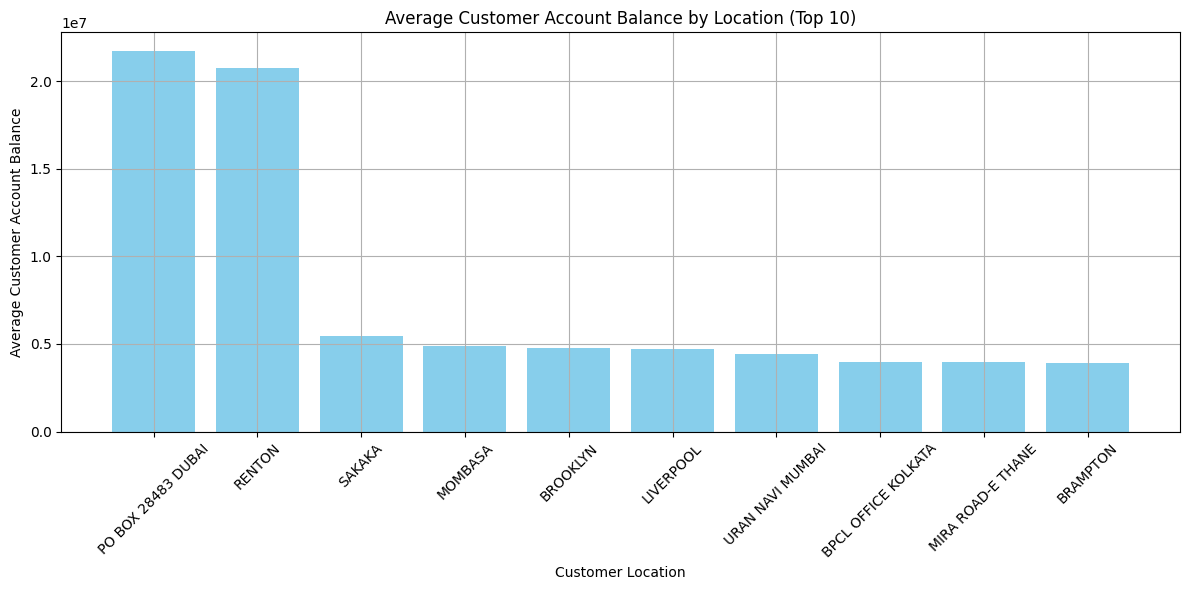

In [ ]:
grouped_data = data.groupby('CustLocation')['CustAccountBalance'].mean().reset_index()

top_10_locations = grouped_data.sort_values(by='CustAccountBalance', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_locations['CustLocation'], top_10_locations['CustAccountBalance'], color='skyblue')
plt.title('Average Customer Account Balance by Location (Top 10)')
plt.xlabel('Customer Location')
plt.ylabel('Average Customer Account Balance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


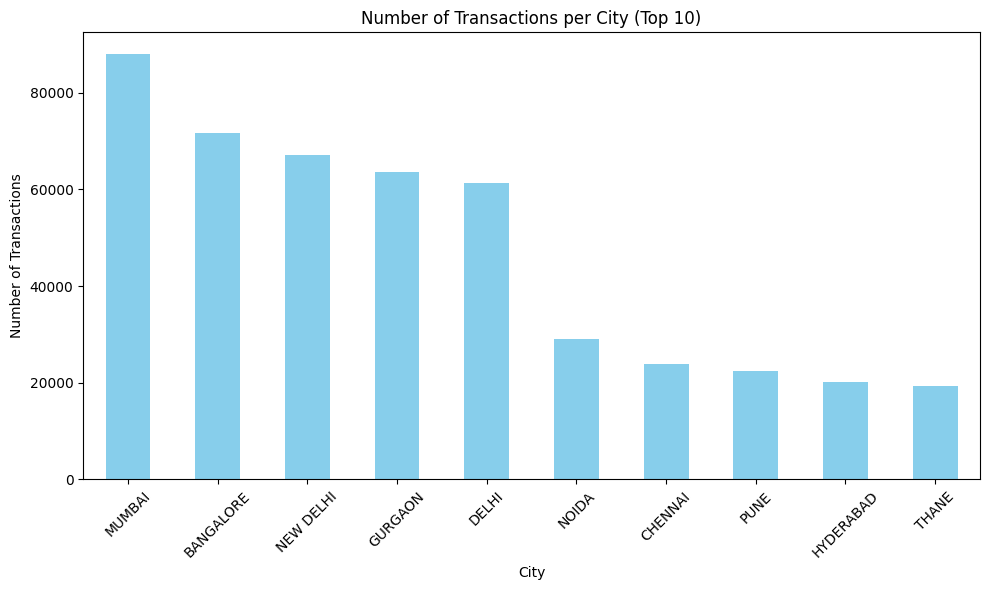

In [ ]:
top_cities = data['CustLocation'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
top_cities.plot(kind='bar', color='skyblue')
plt.title('Number of Transactions per City (Top 10)')
plt.xlabel('City')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Age Based Analysis


<ipython-input-362-2eff2e48329a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data,x='Age',y='CustAccountBalance',palette='ocean')


<Axes: xlabel='Age', ylabel='CustAccountBalance'>

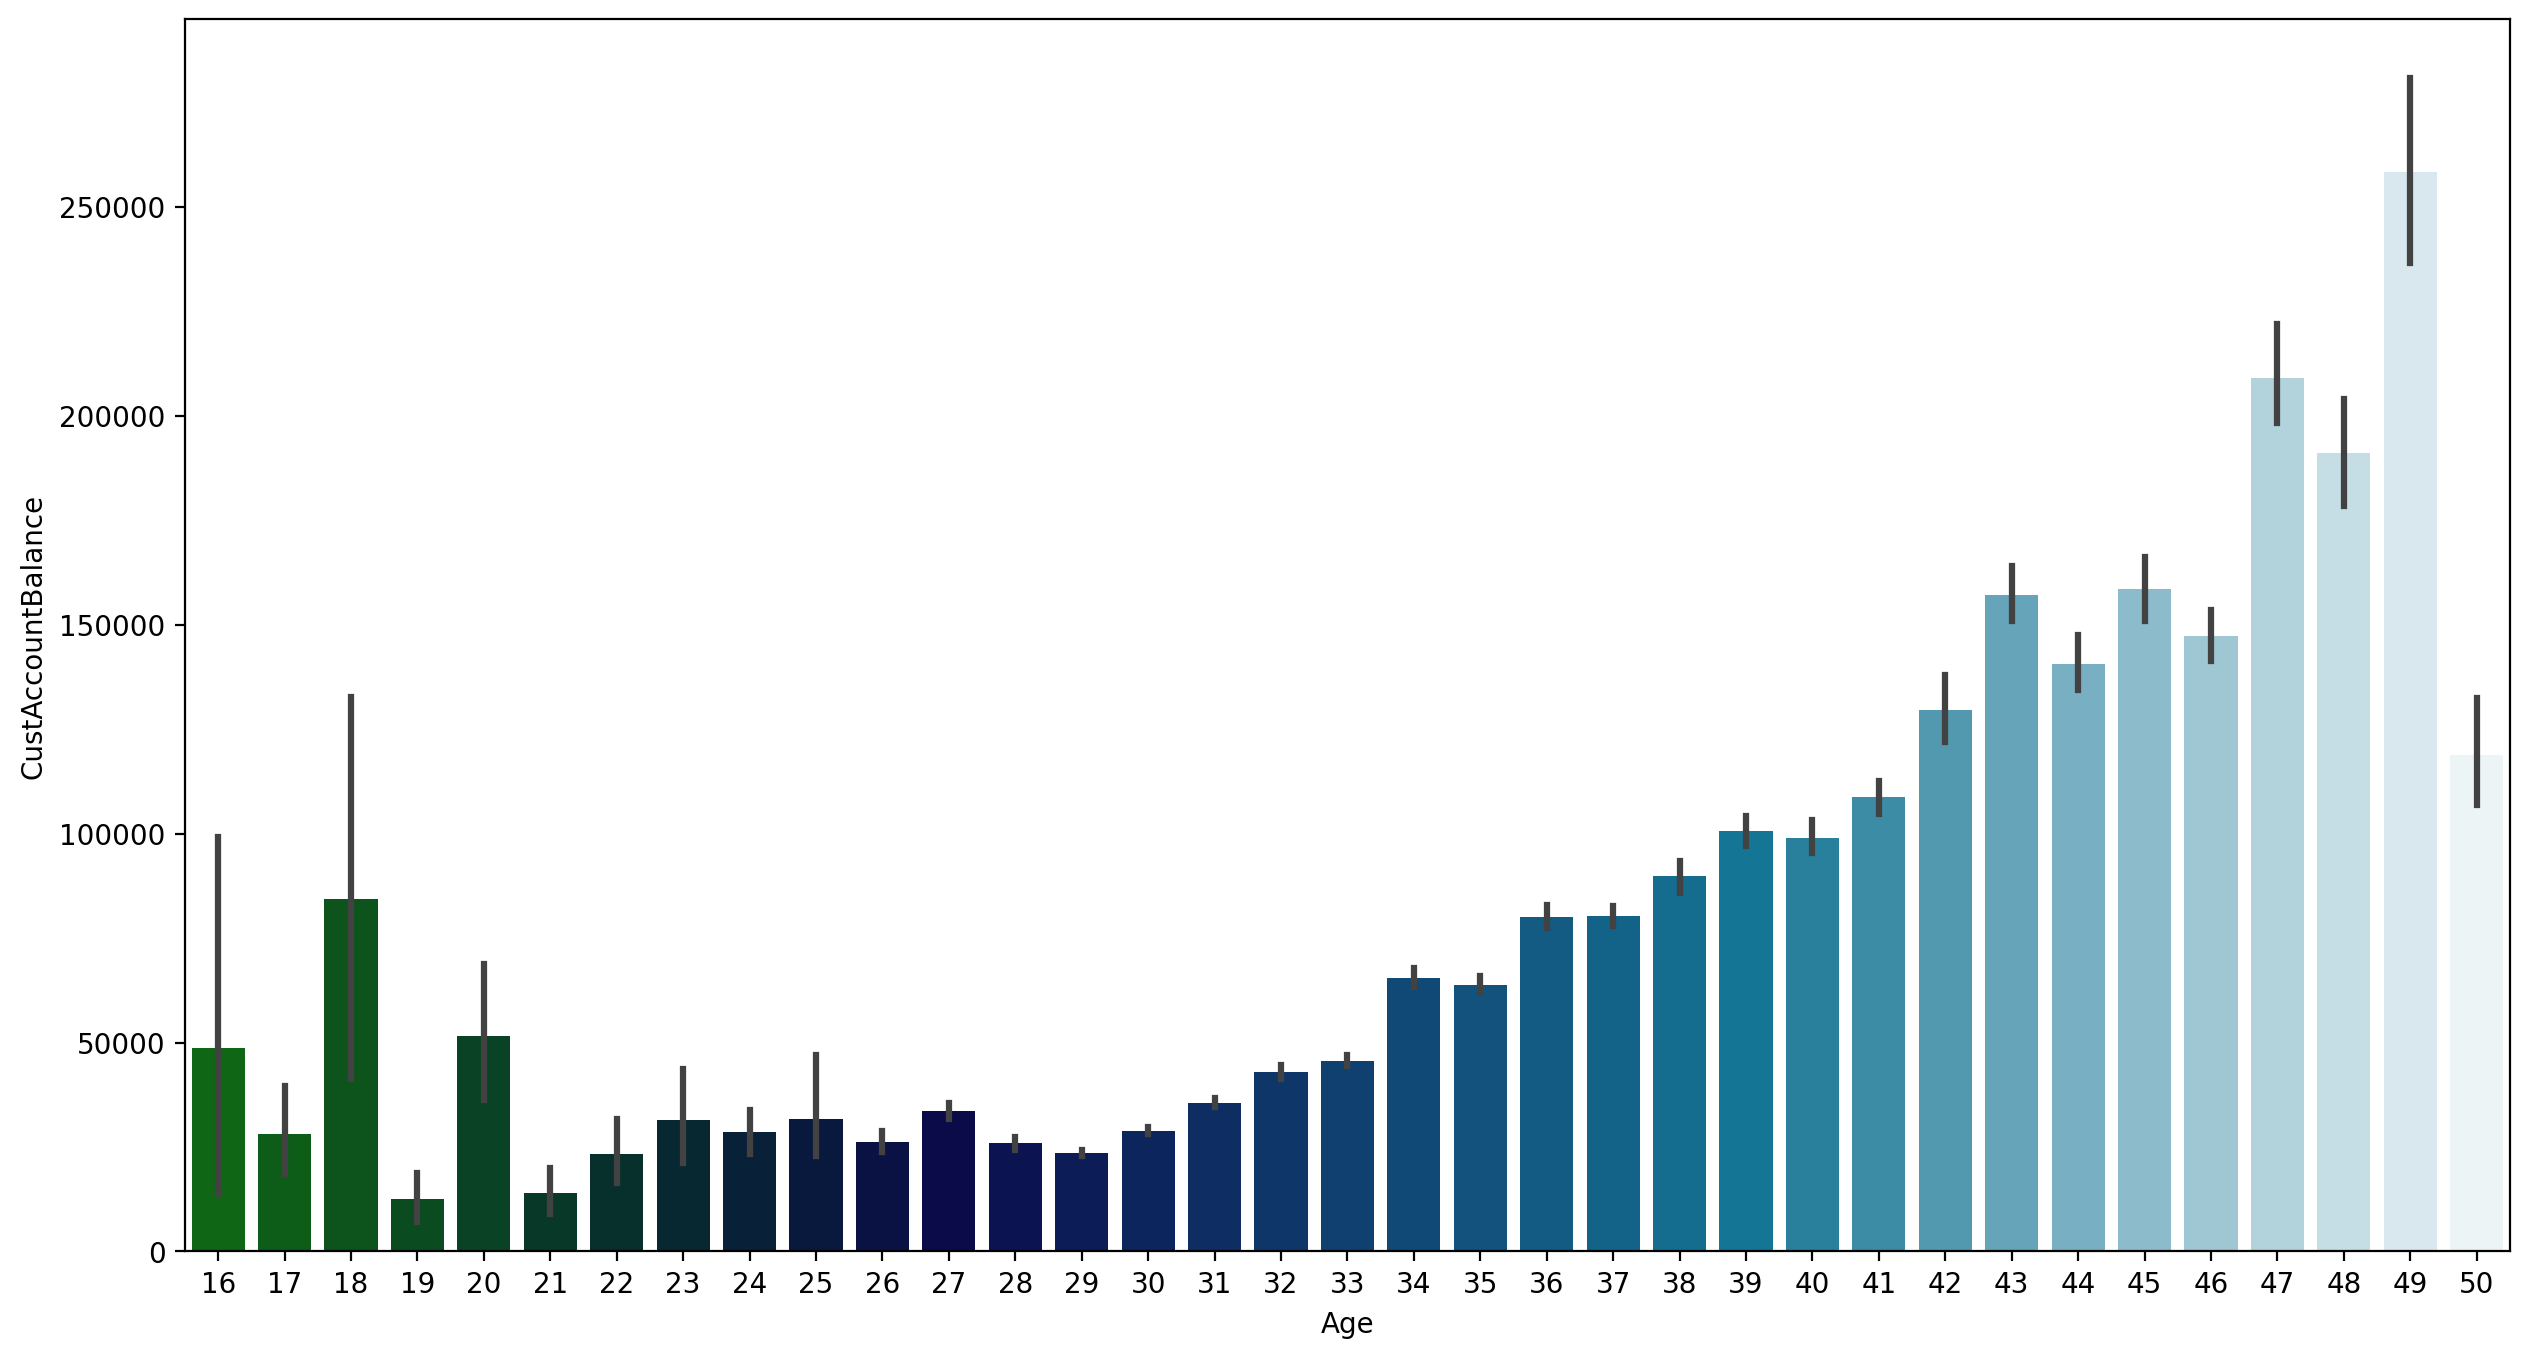

In [ ]:
plt.figure(figsize=(15,8),dpi=200)
sns.barplot(data=data,x='Age',y='CustAccountBalance',palette='ocean')

<ipython-input-363-ebc1a21b9508>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data,x='Age',y='TransactionAmount (INR)',palette='ocean')


<Axes: xlabel='Age', ylabel='TransactionAmount (INR)'>

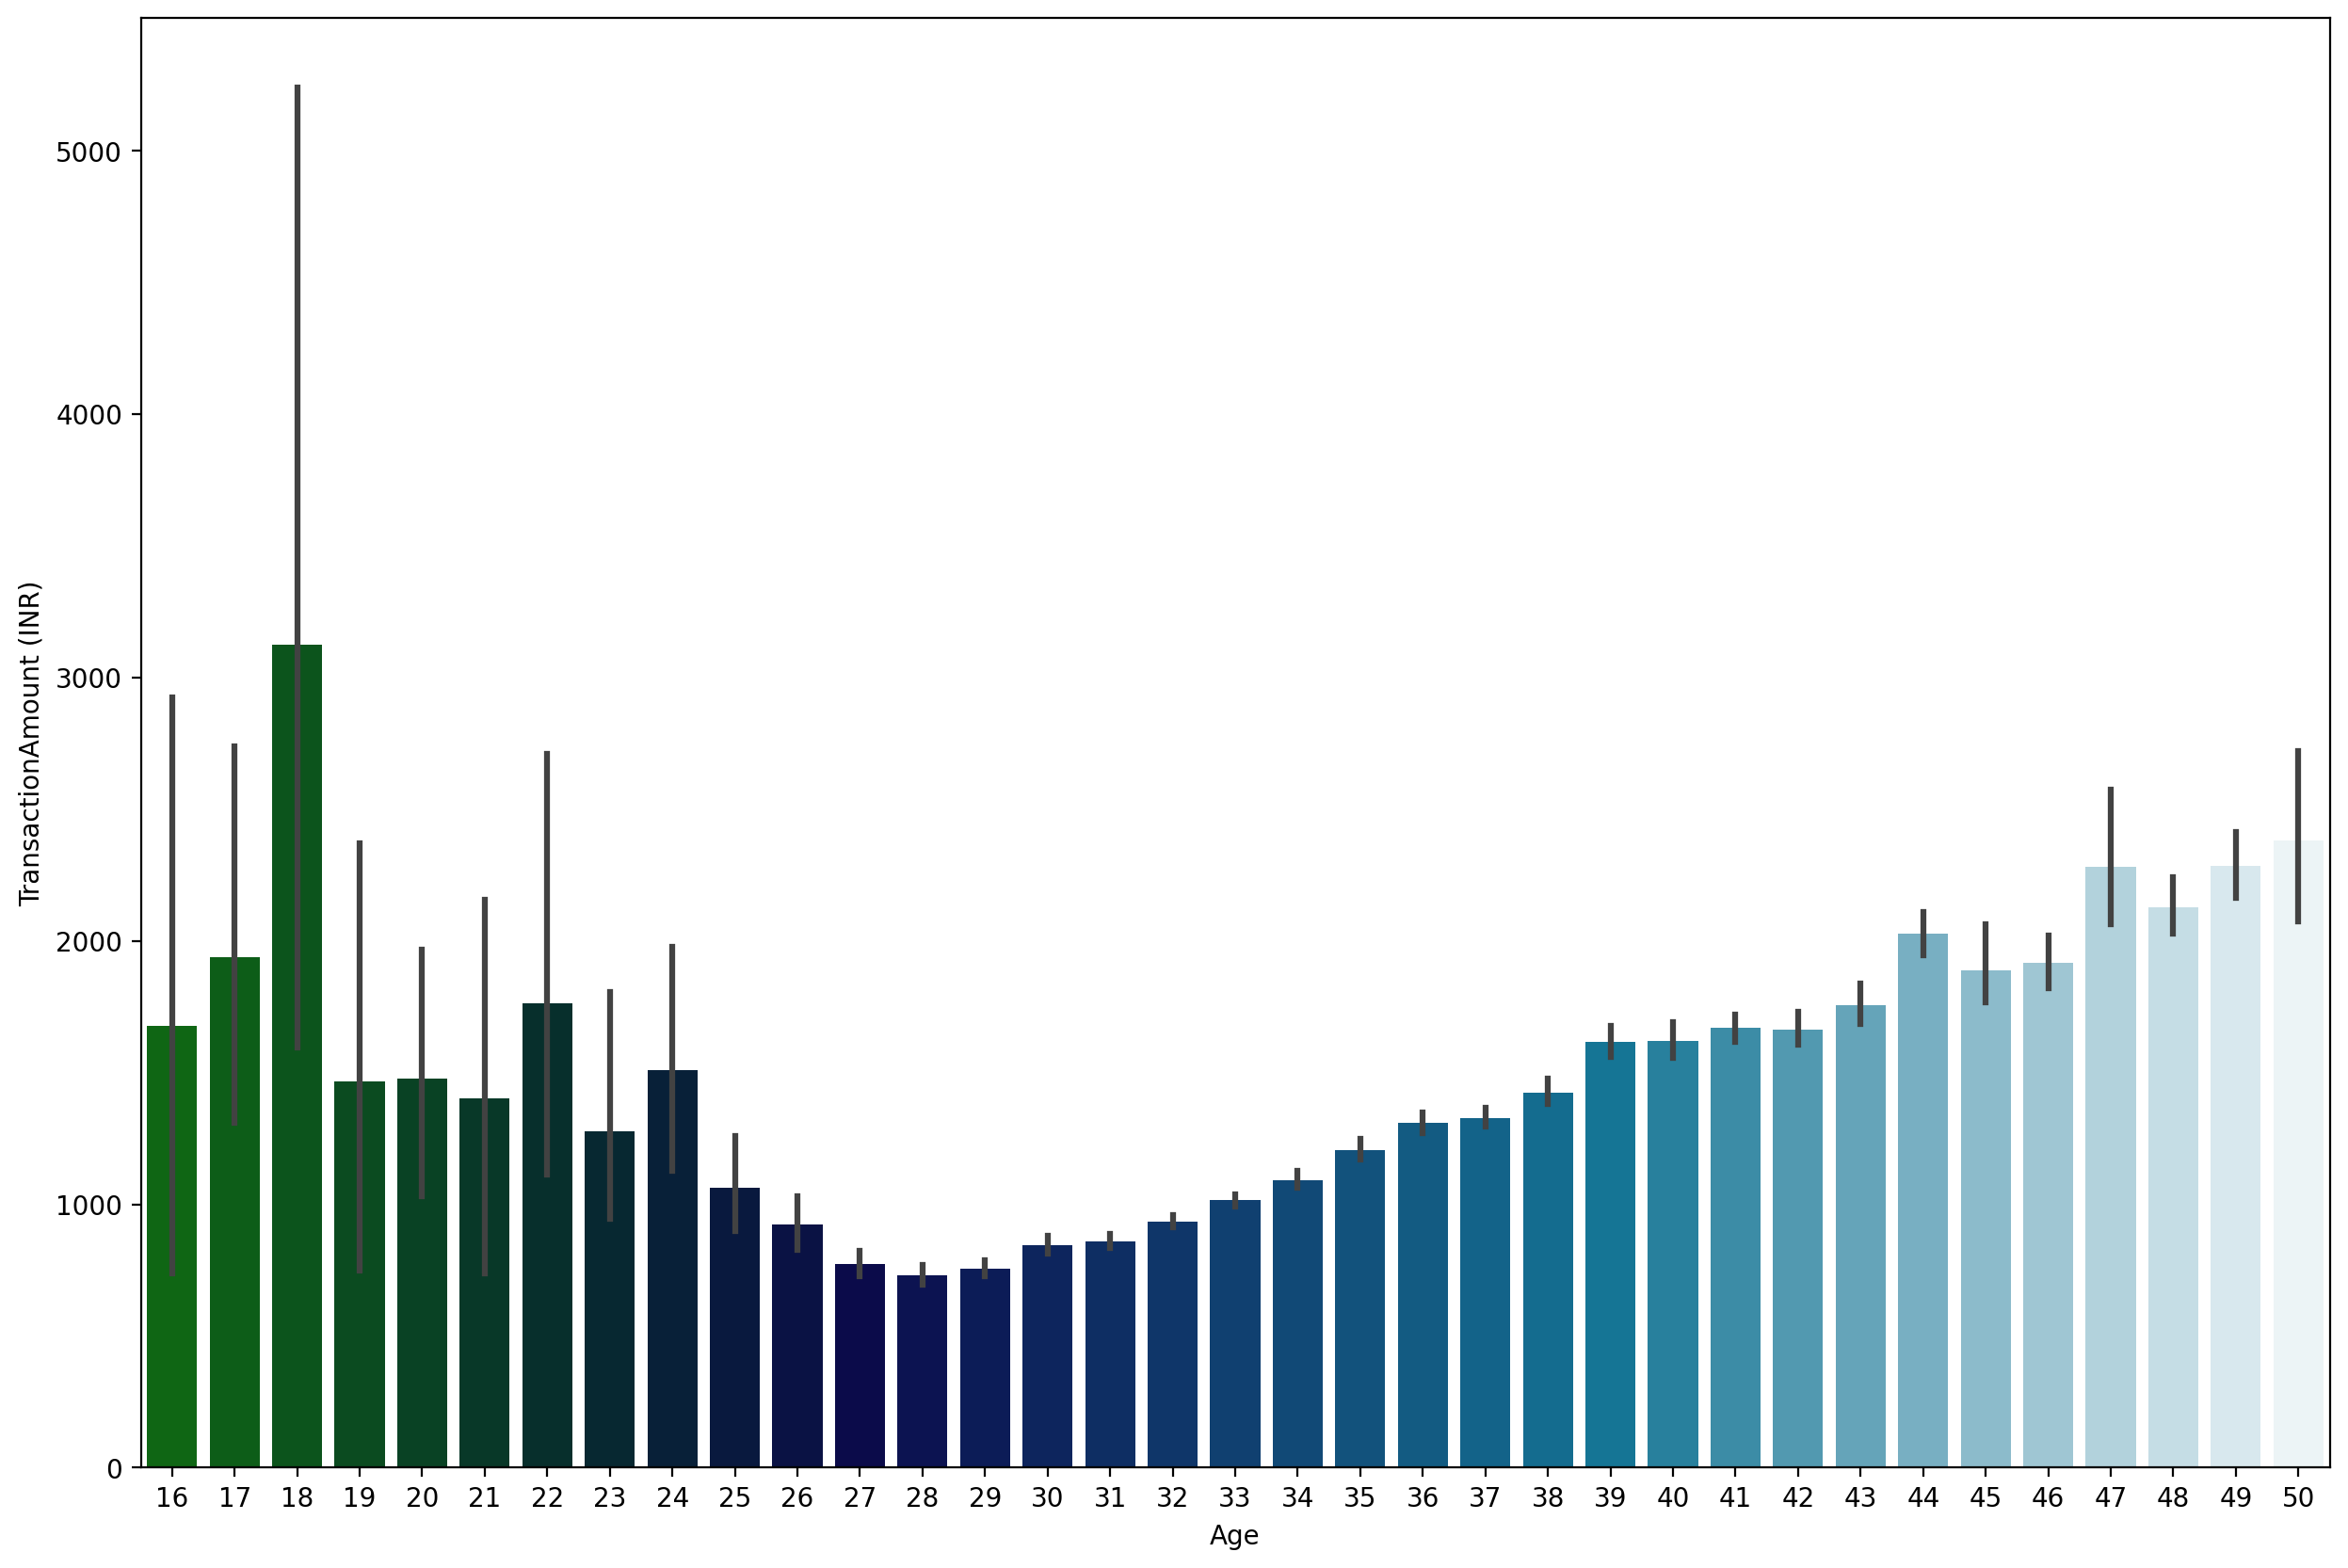

In [ ]:
plt.figure(figsize=(15,10),dpi=200)
sns.barplot(data=data,x='Age',y='TransactionAmount (INR)',palette='ocean')

# Time Based Analysis


<Axes: xlabel='TransactionMonthName', ylabel='TransactionAmount (INR)'>

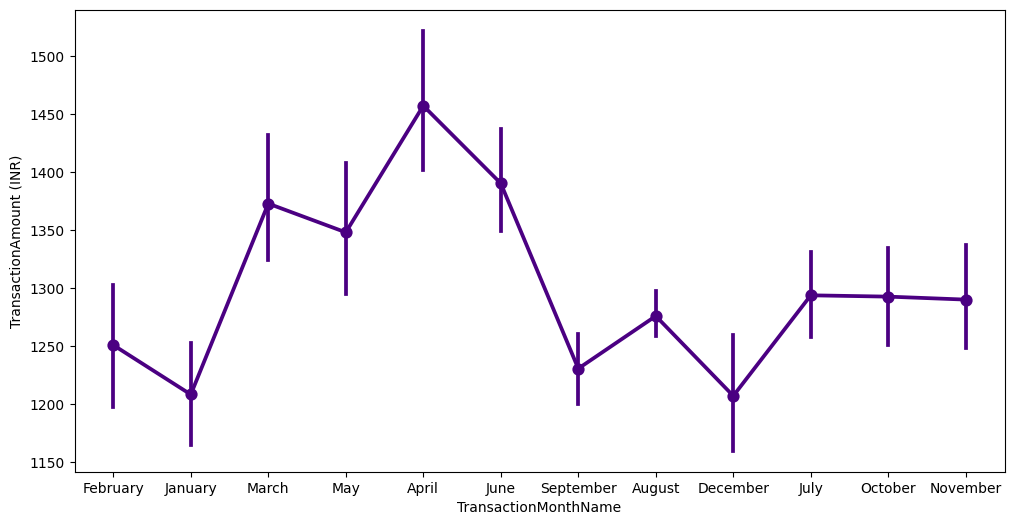

In [ ]:
plt.figure(figsize=(12,6))
sns.pointplot(data=data,x='TransactionMonthName',y='TransactionAmount (INR)',color='indigo')

<Axes: xlabel='TransactionMonthName', ylabel='CustAccountBalance'>

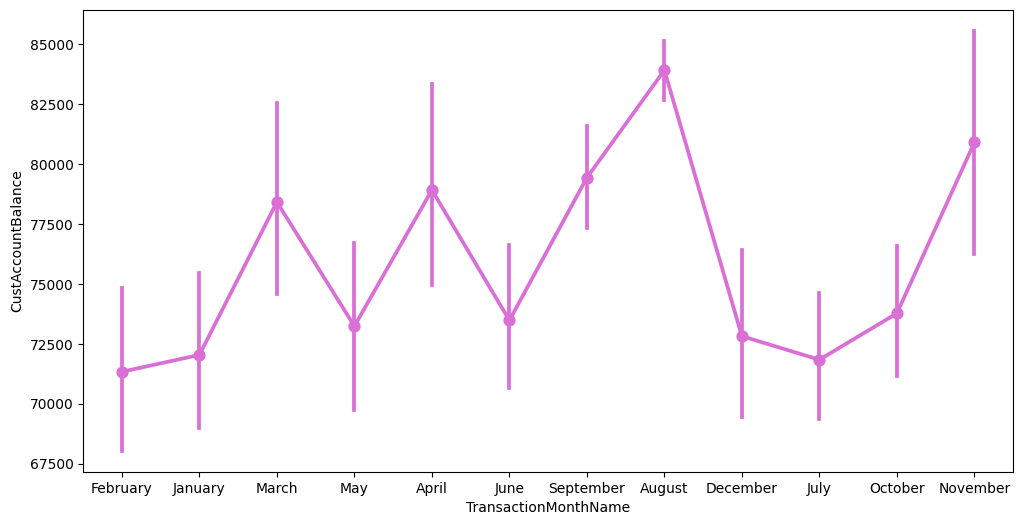

In [ ]:
plt.figure(figsize=(12,6))
sns.pointplot(data=data,x='TransactionMonthName',y='CustAccountBalance',color='orchid')

### Day period activity


In [ ]:
def classify_time_period(transaction_time):
    if pd.isna(transaction_time):
        return 'Unknown'

    time_str = str(transaction_time)
    if len(time_str) < 6:
        return 'Invalid Time'

    hour = int(time_str[:-4])
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

data['TimePeriod'] = data['TransactionTime'].apply(classify_time_period)

print(data)


<ipython-input-313-fff2ca00d16f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TimePeriod'] = data['TransactionTime'].apply(classify_time_period)


        CustGender   CustLocation  CustAccountBalance  TransactionTime  \
0                F     JAMSHEDPUR            17819.05           143207   
2                F         MUMBAI            17874.44           142712   
4                F    NAVI MUMBAI             6714.43           181156   
6                F         MUMBAI              973.46           173806   
7                M         MUMBAI            95075.54           170537   
...            ...            ...                 ...              ...   
1048562          M      NEW DELHI             7635.19           184824   
1048563          M         NASHIK            27311.42           183734   
1048564          M      HYDERABAD           221757.06           183313   
1048565          M  VISAKHAPATNAM            10117.87           184706   
1048566          M           PUNE            75734.42           181222   

         TransactionAmount (INR)  TransactionYear  TransactionMonth  \
0                          25.00        

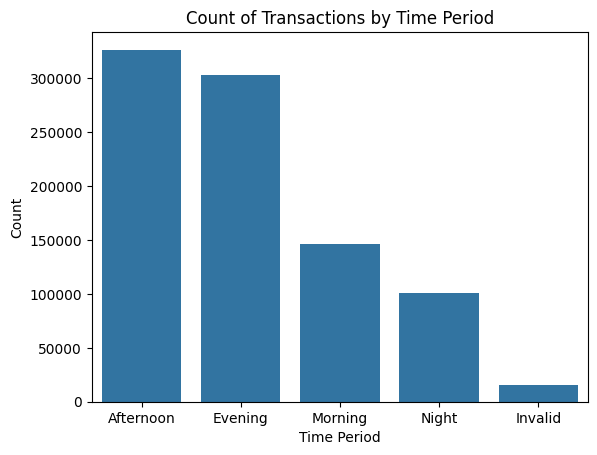

In [ ]:
sns.barplot(x=data['TimePeriod'].value_counts().index, y=data['TimePeriod'].value_counts())
plt.title("Count of Transactions by Time Period")
plt.xlabel("Time Period")
plt.ylabel("Count")
plt.show()

In [ ]:
sns.barplot(x=data['tr_pr'].value_counts().keys(), y=data['tr_pr'].value_counts())
plt.title("count Vs period")
plt.show()


In [ ]:
display(data[data['tr_pr']=='Morning']['TransactionAmount (INR)'].describe(),data[data['tr_pr']=='Night']['TransactionAmount (INR)'].describe())

In [ ]:
data['Atm']=data['tr_pr']=='Night'

### Activity of each hour per day


In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(hh);
plt.xlabel('Day hours')
plt.title("Count vs Day hours")
plt.xticks(range(0,25,1));
plt.show()

### Activity through months

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=data['TransactionMonth'].value_counts().index, y=data['TransactionMonth'].value_counts())
plt.title('Count of Months vs. Transaction Month')
plt.xlabel('Transaction Month')
plt.ylabel('Count of Months')
plt.show()

### Activity through week


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=data['TransactionDayName'].value_counts().index, y=data['TransactionDayName'].value_counts())
plt.title('Count of Weekdays vs. Transaction Weekday')
plt.xlabel('Transaction Weekday')
plt.ylabel('Count of Weekdays')
plt.show()


In [ ]:
data['tr_ratio'] = data['TransactionAmount (INR)'] *100 / (data['CustAccountBalance']+0.01)

In [ ]:
data['deposit']=0


In [ ]:
import pandas as pd

data['deposit'] = data['tr_ratio'] > 100

idx = data[(data['tr_pr'] == 'Night') & (data['TransactionAmount (INR)'] > 30000)].index
data.loc[idx, 'deposit'] = True

idx2 = data[(data['TransactionAmount (INR)'] < 100) & (data['tr_pr'] == 'Night')].index
data.loc[idx2, 'deposit'] = True


In [ ]:
data[data['deposit']==1]['tr_pr'].value_counts().plot(kind='pie',autopct='%.2f');

In [ ]:
data[data['tr_pr']=='Night']['deposit'].value_counts().plot(kind='pie',autopct='%.2f');